# Proyek Klasifikasi Gambar: [Input Nama Dataset]
- **Nama:** Wahyu Azizi
- **Email:** wahyuazizi03@gmail.com
- **ID Dicoding:** wahyuazizi

## Import Semua Packages/Library yang Digunakan

In [1]:
# Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

In [2]:
# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

In [3]:
# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

2025-05-16 08:26:34.760161: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747383994.944775      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747383994.998352      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [6]:
from huggingface_hub import login
login()

In [7]:
from datasets import load_dataset

# Load dataset (hanya ada split 'train')
dataset = load_dataset("rksys/EYE_DISEASE_CLASSIFICATION")

README.md:   0%|          | 0.00/556 [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/346M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/360M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/66.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3795 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/422 [00:00<?, ? examples/s]

### Dataset Checking

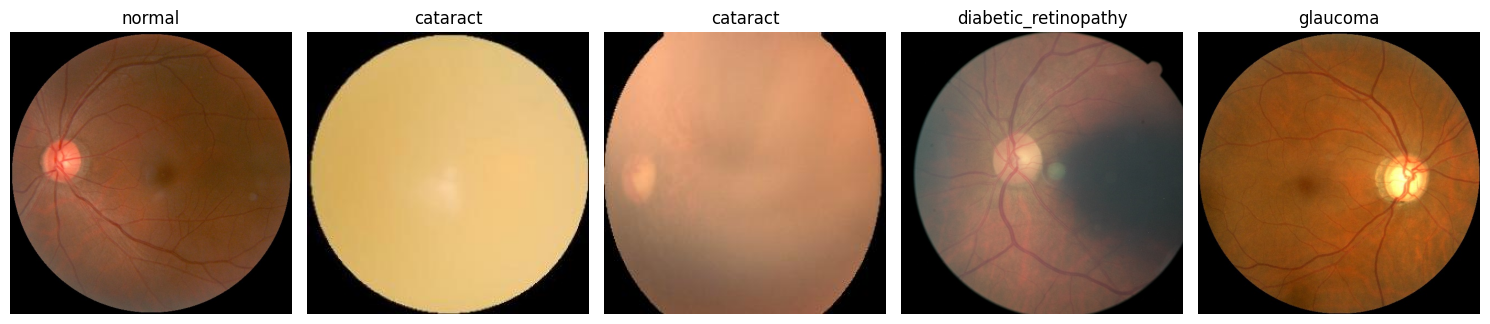

In [8]:
import random
import matplotlib.pyplot as plt
from datasets import load_dataset

# Load dataset
label_names = dataset['train'].features['label'].names

# Ambil 5 contoh acak
examples = random.sample(list(dataset['train']), 5)

# Tampilkan gambar
plt.figure(figsize=(15, 5))
for i, example in enumerate(examples):
    img = example['image']
    label = label_names[example['label']]

    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()


### Plot Distribusi

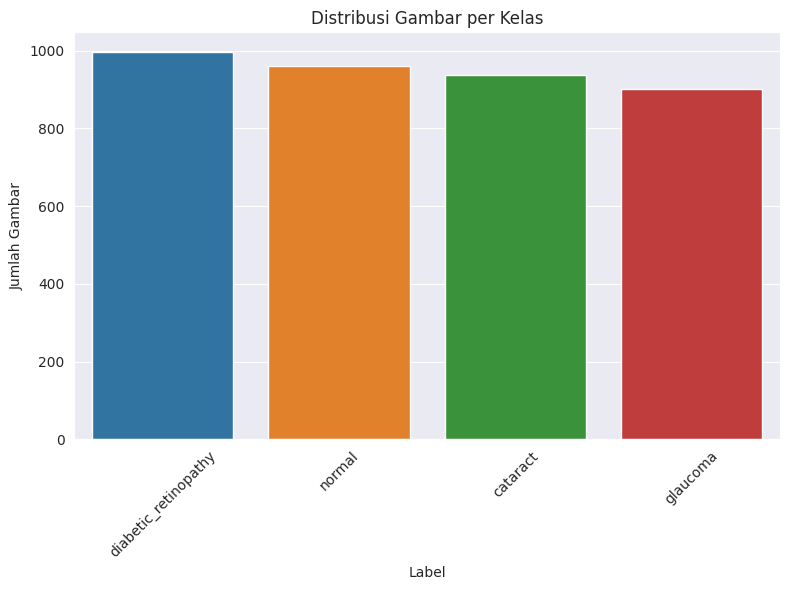

In [9]:
import seaborn as sns

# Ambil semua label
labels = [label_names[example['label']] for example in dataset['train']]

# Buat DataFrame
df = pd.DataFrame({'label': labels})

# Plot distribusi
plt.figure(figsize=(8,6))
sns.set_style("darkgrid")
sns.countplot(data=df, x='label', order=df['label'].value_counts().index)
plt.title('Distribusi Gambar per Kelas')
plt.xlabel('Label')
plt.ylabel('Jumlah Gambar')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Data Preprocessing

#### Split Dataset

In [10]:
# Bagi manual: 80% train, 20% validation
train_valid_split = dataset['train'].train_test_split(test_size=0.2, seed=42)

train_dataset = train_valid_split['train']
valid_dataset = train_valid_split['test']
test_dataset  = dataset['test']  # ini yang dari dataset asli

#### Image Preprocessing

In [11]:
BATCH_SIZE = 32
IMAGE_SIZE = (150, 150)
def preprocess(example):
    image = example["image"]
    image = tf.image.resize(image, (150, 150))     # Resize dengan TensorFlow
    image = image / 255.0                          # Normalisasi ke [0, 1]
    return {"image": image, "label": example["label"]}

In [12]:
# Terapkan preprocessing ke setiap dataset
train_dataset = train_dataset.map(preprocess)
valid_dataset = valid_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

Map:   0%|          | 0/3036 [00:00<?, ? examples/s]

I0000 00:00:1747384086.713985      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Map:   0%|          | 0/759 [00:00<?, ? examples/s]

Map:   0%|          | 0/422 [00:00<?, ? examples/s]

In [13]:
# Konversi dan batching
train_dataset = train_dataset.with_format("tensorflow")
valid_dataset = valid_dataset.with_format("tensorflow")
test_dataset = test_dataset.with_format("tensorflow")

train_tf_dataset = train_dataset.to_tf_dataset(
    columns=["image"],
    label_cols="label",
    shuffle=True,
    batch_size=BATCH_SIZE,
).prefetch(tf.data.AUTOTUNE)

val_tf_dataset = valid_dataset.to_tf_dataset(
    columns=["image"],
    label_cols="label",
    shuffle=False,
    batch_size=BATCH_SIZE,
).prefetch(tf.data.AUTOTUNE)

test_tf_dataset = test_dataset.to_tf_dataset(
    columns=["image"],
    label_cols="label",
    shuffle=False,
    batch_size=1,
).prefetch(tf.data.AUTOTUNE)

## Modelling

In [14]:
model = keras.Sequential([
    keras.Input(shape=(150,150,3)),
    keras.layers.Conv2D(32, (3,3), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Conv2D(32, (3,3), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Conv2D(32, (3,3), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D((2,2)),

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(4, activation="softmax"),
])

In [15]:
model.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 37, 37, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,327,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,355,524 (5.17 MB)

 Trainable params: 1,355,332 (5.17 MB)

 Non-trainable params: 192 (768.00 B)

In [17]:
# Callback
from tensorflow.keras.callbacks import Callback

class StopTrainingAtAccuracy(Callback):
    def __init__(self, threshold=0.87):
        super().__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get("val_accuracy")  # atau "accuracy" jika kamu tidak pakai validasi
        if accuracy is not None:
            if accuracy > self.threshold:
                print(f"\n⏹ Training dihentikan karena val_accuracy > {self.threshold*100:.2f}%")
                self.model.stop_training = True
                
my_callback = [
    keras.callbacks.ModelCheckpoint(
        'best_model.h5', 
        monitor='val_accuracy', 
        save_best_only=True, 
        mode='max'
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=10, 
        restore_best_weights=True
    ),
    keras.callbacks.TensorBoard(
        log_dir = './logs', update_freq='batch'
    ),
    StopTrainingAtAccuracy(threshold=0.87)
]


In [18]:
history = model.fit(
    train_tf_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_tf_dataset,
    callbacks=my_callback,
    verbose=1
)

Epoch 1/50


I0000 00:00:1747384910.311883     115 service.cc:148] XLA service 0x7a272c045a00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747384910.312745     115 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747384911.400839     115 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1747384915.292445     115 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


95/95 ━━━━━━━━━━━━━━━━━━━━ 504s 5s/step - accuracy: 0.4586 - loss: 2.9999 - val_accuracy: 0.2675 - val_loss: 2.7562
Epoch 2/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 498s 5s/step - accuracy: 0.6131 - loss: 0.9904 - val_accuracy: 0.2859 - val_loss: 2.4884
Epoch 3/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 499s 5s/step - accuracy: 0.6576 - loss: 0.8210 - val_accuracy: 0.4598 - val_loss: 1.3788
Epoch 4/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 501s 5s/step - accuracy: 0.7079 - loss: 0.6895 - val_accuracy: 0.4440 - val_loss: 1.3865
Epoch 5/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 503s 5s/step - accuracy: 0.7584 - loss: 0.6138 - val_accuracy: 0.4954 - val_loss: 1.0248
Epoch 6/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 498s 5s/step - accuracy: 0.7972 - loss: 0.5277 - val_accuracy: 0.4901 - val_loss: 0.9634
Epoch 7/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 499s 5s/step - accuracy: 0.7959 - loss: 0.5411 - val_accuracy: 0.6877 - val_loss: 0.6948
Epoch 8/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 499s 5s/step - accuracy: 0.8316 - loss: 0.4453 - val_accuracy: 0.7826 - val_loss: 0.

## Evaluasi dan Visualisasi

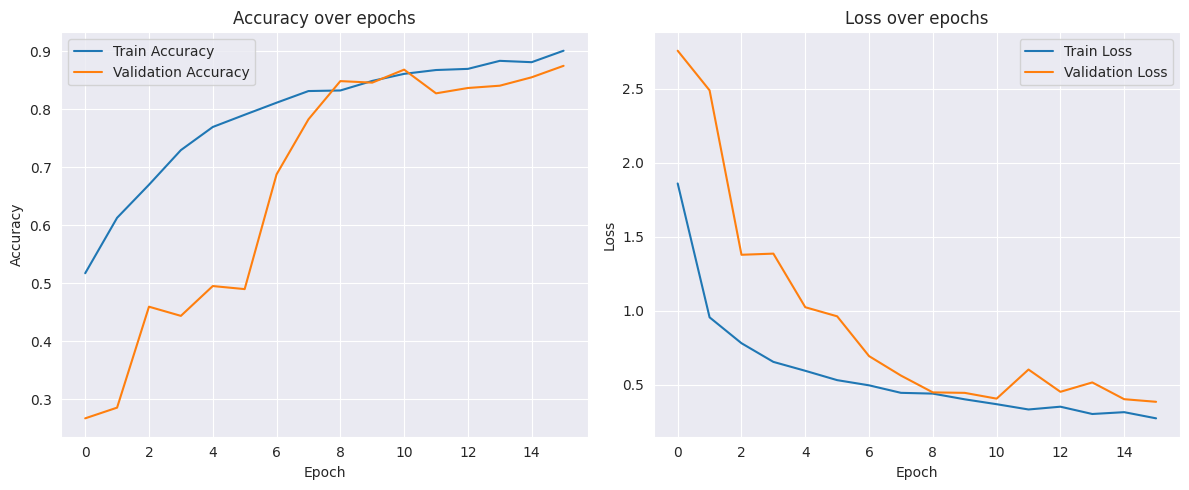

In [19]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
# Evaluate on test dataset
test_loss, test_acc = model.evaluate(test_tf_dataset)
print(f"Test accuracy: {test_acc:.2f}")
print(f"Test loss: {test_loss:.2f}")

422/422 ━━━━━━━━━━━━━━━━━━━━ 57s 135ms/step - accuracy: 0.8260 - loss: 0.4509
Test accuracy: 0.85
Test loss: 0.40


In [22]:
# Get predictions
all_labels = []
all_predictions = []

for images, labels in test_tf_dataset:
    pred = model.predict(images, verbose=0)
    pred_class = np.argmax(pred, axis=1)
    all_predictions.extend(pred_class)
    all_labels.extend(labels.numpy())

# Print Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)
cm_df = pd.DataFrame(data=cm, 
                     index=label_names,
                     columns=label_names)


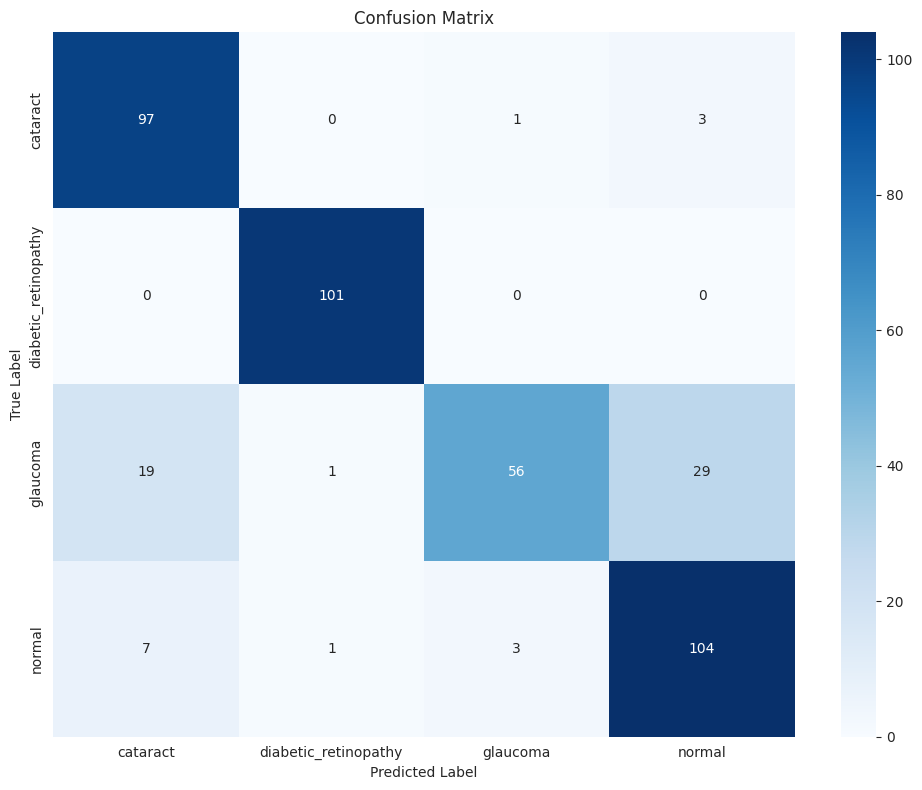

In [23]:
plt.figure(figsize=(10,8))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [24]:
# Print Classification Report
print("\nClassification Report:")
print(classification_report(
    y_true=all_labels,
    y_pred=all_predictions,
    target_names=label_names, 
    digits=4
))


Classification Report:
                      precision    recall  f1-score   support

            cataract     0.7886    0.9604    0.8661       101
diabetic_retinopathy     0.9806    1.0000    0.9902       101
            glaucoma     0.9333    0.5333    0.6788       105
              normal     0.7647    0.9043    0.8287       115

            accuracy                         0.8483       422
           macro avg     0.8668    0.8495    0.8409       422
        weighted avg     0.8641    0.8483    0.8390       422



## Konversi Model

In [36]:
# Saved Model
save_path = 'saved_model/'
tf.saved_model.save(model, save_path)
print(f"Model saved to {save_path}")

Model saved to saved_model/


In [26]:
# # Save as H5 format
# model.save('eye_disease_model.h5')
# print("Model saved as eye_disease_model.h5")

In [33]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is incompatible.
pandas-gbq 0.28.0 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible

In [38]:
# Convert ke TensorFlow.js

!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    saved_model \
    tfjs_model

2025-05-16 11:14:07.157745: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747394047.177890    5806 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747394047.183920    5806 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
I0000 00:00:1747394052.125913    5806 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13699 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
I0000 00:00:1747394052.466391    5806 devices.cc:67] Number of eligible GPUs (core co

In [40]:
import os

# Convert ke TFLite
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')
tflite_model = converter.convert()

# Buat folder jika belum ada
os.makedirs('tflite', exist_ok=True)

# Simpan file .tflite
with open('tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)

W0000 00:00:1747394146.857104      35 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1747394146.857139      35 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


In [42]:
# Simpan label.txt
labels = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
with open('tflite/label.txt', 'w') as f:
    f.write('\n'.join(labels))

## Inference (Optional)

In [49]:
import requests

def load_and_preprocess_image(image_path_or_url, target_size=(150, 150)):
    """
    Load dan preprocess gambar untuk inference
    
    Args:
        image_path: Path ke file gambar
        target_size: Ukuran target untuk resize
        
    Returns:
        Gambar yang sudah dipreprocess dalam bentuk array numpy
    """
    # Load gambar
    if image_path_or_url.startswith('http://') or image_path_or_url.startswith('https://'):
        response = requests.get(image_path_or_url)
        img = Image.open(BytesIO(response.content))
    else:
        img = Image.open(image_path_or_url)
    
    img = img.resize(target_size)
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    return img_array

In [54]:
def predict_eye_disease(model_path, image_path_or_url):
    """
    Melakukan prediksi penyakit mata menggunakan model yang sudah dilatih
    
    Args:
        model_path: Path ke model tersimpan (H5 atau SavedModel)
        image_path: Path ke gambar yang akan diprediksi
        
    Returns:
        Kelas prediksi dan probabilitasnya
    """
    # Daftar kelas penyakit mata
    class_names = ["cataract", "diabetic_retinopathy", "glaucoma", "normal"]
    
    # Load model
    try:
        # Coba load sebagai SavedModel
        model = tf.keras.models.load_model(model_path)
        print(f"Model berhasil dimuat dari {model_path}")
    except:
        # Jika gagal, coba load sebagai file H5
        model = tf.keras.models.load_model(model_path)
        print(f"Model berhasil dimuat dari {model_path}")
    
    # Load dan preprocess gambar
    preprocessed_img = load_and_preprocess_image(image_path)
    
    # Lakukan prediksi
    predictions = model.predict(preprocessed_img)
    
    # Dapatkan indeks kelas dengan probabilitas tertinggi
    predicted_class_index = np.argmax(predictions[0])
    predicted_class = class_names[predicted_class_index]
    confidence = float(predictions[0][predicted_class_index])
    
    # Visualisasi hasil
    plt.figure(figsize=(8, 6))
    
    # Tampilkan gambar
    plt.subplot(1, 2, 1)
    if image_path_or_url.startswith('http://') or image_path_or_url.startswith('https://'):
        response = requests.get(image_path_or_url)
        img = Image.open(BytesIO(response.content))
    else:
        img = Image.open(image_path_or_url)
    plt.imshow(img)
    plt.title("Gambar Input")
    plt.axis("off")
    
    # Tampilkan grafik probabilitas
    plt.subplot(1, 2, 2)
    plt.bar(class_names, predictions[0])
    plt.title("Probabilitas Prediksi")
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return {
        "predicted_class": predicted_class,
        "confidence": confidence,
        "probabilities": {class_names[i]: float(predictions[0][i]) for i in range(len(class_names))}
    }

Model berhasil dimuat dari best_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step

Hasil Prediksi:
Kelas Prediksi: glaucoma
Tingkat Keyakinan: 99.90%

Probabilitas per Kelas:
- cataract: 0.10%
- diabetic_retinopathy: 0.00%
- glaucoma: 99.90%
- normal: 0.00%


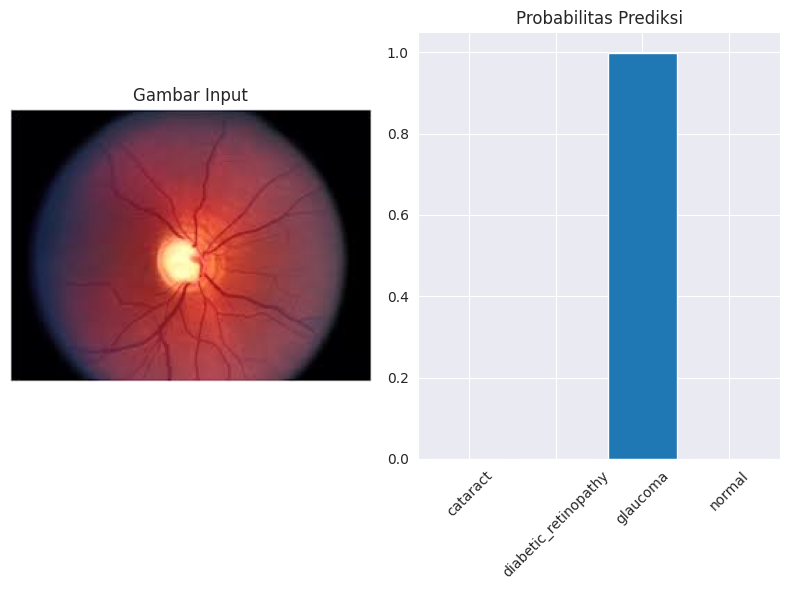

In [69]:
from io import BytesIO
# Contoh penggunaan:
"""
Gambar didapat dalam laman berikut: https://specialtyicare.com/what-is-a-glaucoma-specialist/
"""
if __name__ == "__main__":
    # Path ke model dan gambar
    model_path = "best_model.h5"
    image_path = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTUwLhu48VSA1vdxflYSm9QgL65ZMPu9KJMSw&s" 
    
    # Jalankan prediksi
    result = predict_eye_disease(model_path, image_path)
    
    # Tampilkan hasil
    print(f"\nHasil Prediksi:")
    print(f"Kelas Prediksi: {result['predicted_class']}")
    print(f"Tingkat Keyakinan: {result['confidence']*100:.2f}%")
    print("\nProbabilitas per Kelas:")
    for cls, prob in result["probabilities"].items():
        print(f"- {cls}: {prob*100:.2f}%")
    
    plt.show()

## Prepare Requirements dan Folder

In [70]:
# Buat file requirements.txt dari pip freeze
!pip freeze > requirements.txt

In [77]:
!zip -r working.zip ./*

  adding: best_model.h5 (deflated 7%)
  adding: eye_disease_model.tflite (deflated 73%)
  adding: label_map.json (stored 0%)
  adding: logs/ (stored 0%)
  adding: logs/validation/ (stored 0%)
  adding: logs/validation/events.out.tfevents.1747385307.ca81f047ac7f.35.1.v2 (deflated 74%)
  adding: logs/train/ (stored 0%)
  adding: logs/train/events.out.tfevents.1747384903.ca81f047ac7f.35.0.v2 (deflated 76%)
  adding: mymodel/ (stored 0%)
  adding: mymodel/variables/ (stored 0%)
  adding: mymodel/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: mymodel/variables/variables.index (deflated 66%)
  adding: mymodel/saved_model.pb (deflated 87%)
  adding: mymodel/assets/ (stored 0%)
  adding: mymodel/fingerprint.pb (stored 0%)
  adding: requirements.txt (deflated 57%)
  adding: saved_model/ (stored 0%)
  adding: saved_model/variables/ (stored 0%)
  adding: saved_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: saved_model/variables/variables.index (deflated 66%

In [79]:
from IPython.display import FileLink
FileLink('working.zip')   # atau 'working.zip'

/kaggle/working/working.zip